# Fine-tuning Gemma 3 for Bidirectional Morse Code Translation

This notebook performs the following steps:
- Load the pretrained Gemma 3 1B model as the base
- Load a dataset and convert it into the required chat format
- Fine-tune the base model
- Save the fine-tuned model locally and upload it to Hugging Face

**Credits**: This work is based on the excellent [Unsloth](https://unsloth.ai/) team's [Gemma 3 Notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Gemma3_(4B).ipynb).

In [1]:
from unsloth import FastModel

model, tokenizer = FastModel.from_pretrained(
    #model_name = "unsloth/gemma-3-1b-pt-unsloth-bnb-4bit",
    model_name = "google/gemma-3-1b-pt",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Gemma3 patching. Transformers: 4.50.0.dev0.
   \\   /|    Quadro RTX 5000. Num GPUs = 1. Max memory: 16.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


## Load LoRA adapters

Use PEFT (Parameter-Efficient-Fine-Tuning) to only adjust a small subsest of model's parameters.

In [2]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


Unsloth makes it really easy to locate the correct chat template for a given tokenizer

In [3]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

Load the previous prepared data as prepared in the `01-build-dataset.ipynb` notebook.  This dataset contains about 50K rows with English and its equivalent Morse Code

In [4]:
from datasets import load_dataset
dataset = load_dataset("philipfourie/books3_basic_sentenses_paraphrased-Morse", split="train")
dataset

Dataset({
    features: ['line', 'morse'],
    num_rows: 531976
})

In [5]:
dataset[0]

{'line': 'The title was cataloged by the Library of Congress.',
 'morse': '- .... . / - .. - .-.. . / .-- .- ... / -.-. .- - .- .-.. --- --. . -.. / -... -.-- / - .... . / .-.. .. -... .-. .- .-. -.-- / --- ..-. / -.-. --- -. --. .-. . ... ... .-.-.-'}

For this fine-tuning, the goal is to train the model to translate both from English to Morse Code and from Morse Code back to English.  
Since the original dataset doesn’t include any information about the translation direction, the code randomly assigns a tag to each example — either `to_morse` or `to_text` — to indicate which way the translation should go.

In [6]:
import random

n = len(dataset)

# build a list with half “to_morse” and half “to_text”
directions = ["to_morse"] * (n // 2) + ["to_text"] * (n - n // 2)

# shuffle in-place (set seed for reproducibility if you like)
random.seed(42)
random.shuffle(directions)

# attach it to your Dataset
dataset = dataset.add_column("direction", directions)


Quickly check whether the distribution of the direction tags (`to_morse` and `to_text`) is balanced.

In [7]:
from collections import Counter

counts = Counter(dataset["direction"])
print(counts)

Counter({'to_morse': 265988, 'to_text': 265988})


Convert the dataset into a **OpenAPI chat API format**-compatible format.  
Although Gemma 3 uses its own chat template, it's more convenient and easier to read if we first convert the data into this intermediate format.  
Later, in a few steps, it will be transformed into the Gemma 3-specific chat template.

In [8]:
def apply_conversations(example):
    if example["direction"] == "to_morse":
        source = "line"
        target = "morse"
    else:
        source = "morse"
        target = "line"

    return {
        "conversations": [
            {
                "content": example[source],
                "role": "user",
            },
            {
                "content": example[target] + tokenizer.eos_token, # Note the use of end of sentence token, this teaches the model to stop at the right time.
                "role": "assistant",
            },
        ]
    }


In [9]:
convos = dataset.map(apply_conversations, remove_columns = ["line", "morse"])
convos

Dataset({
    features: ['direction', 'conversations'],
    num_rows: 531976
})

In [10]:
print(convos[0])
print(convos[3])

{'direction': 'to_morse', 'conversations': [{'content': 'The title was cataloged by the Library of Congress.', 'role': 'user'}, {'content': '- .... . / - .. - .-.. . / .-- .- ... / -.-. .- - .- .-.. --- --. . -.. / -... -.-- / - .... . / .-.. .. -... .-. .- .-. -.-- / --- ..-. / -.-. --- -. --. .-. . ... ... .-.-.-<eos>', 'role': 'assistant'}]}
{'direction': 'to_text', 'conversations': [{'content': '.-- .... . .-. . / .. ... / -- -.-- / -- --- - .... . .-. ..--..', 'role': 'user'}, {'content': 'Where is my mother?<eos>', 'role': 'assistant'}]}


Now that the dataset is randomised for `direction` and properly formatted in **OpenAI chat API format** , we can proceed to convert it into the format required by Gemma 3 using the `apply_chat_template` function provided by Unsloth.  
The result is stored in the `text` column, which the training step relies on.  
As an optional cleanup step, the obsolete `conversations` and `direction` columns are removed.

In [11]:
def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

convos = convos.map(formatting_prompts_func, remove_columns=["conversations", "direction"], batched = True)
convos

Dataset({
    features: ['text'],
    num_rows: 531976
})

In [12]:
print(convos["text"][0])
print(convos["text"][3])

<start_of_turn>user
The title was cataloged by the Library of Congress.<end_of_turn>
<start_of_turn>model
- .... . / - .. - .-.. . / .-- .- ... / -.-. .- - .- .-.. --- --. . -.. / -... -.-- / - .... . / .-.. .. -... .-. .- .-. -.-- / --- ..-. / -.-. --- -. --. .-. . ... ... .-.-.-<eos><end_of_turn>

<start_of_turn>user
.-- .... . .-. . / .. ... / -- -.-- / -- --- - .... . .-. ..--..<end_of_turn>
<start_of_turn>model
Where is my mother?<eos><end_of_turn>



Split the dataset into train and test

In [13]:
train_dataset = convos.train_test_split(test_size=0.1, seed=42)["train"]
test_dataset  = convos.train_test_split(test_size=0.1, seed=42)["test"]

del convos, dataset # No longer needed

In [14]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,

    train_dataset = train_dataset,
    eval_dataset  = test_dataset.select(range(0, 1000)), # Use a subset for testing

    args = SFTConfig(
        dataset_text_field="text",
        dataset_num_proc=4,

        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs        
        warmup_steps = 2, # 15
        #num_train_epochs = 1.5, 
        max_steps = 201, 
        eval_steps = 50,  # Enable evaluation logging
        eval_strategy = "steps",
        logging_steps = 1,  # Log every step for testing
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,

        report_to = "tensorboard", # Use this for WandB etc
        logging_dir = "outputs/tensorboard_logs",  # Subdirectory for TensorBoard logs
        output_dir = "outputs",  # Explicitly set output directory
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


In [15]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

In [16]:
trainer.train_dataset[0]["input_ids"]

[2,
 105,
 2364,
 107,
 23621,
 3307,
 691,
 236390,
 580,
 506,
 18410,
 1056,
 668,
 691,
 1806,
 1518,
 2255,
 236761,
 106,
 107,
 105,
 4368,
 107,
 1390,
 199900,
 2617,
 2617,
 72213,
 726,
 965,
 783,
 726,
 199900,
 3729,
 965,
 3729,
 753,
 2728,
 236772,
 72213,
 2617,
 236761,
 965,
 9190,
 72213,
 965,
 753,
 27103,
 783,
 965,
 72213,
 9190,
 3729,
 783,
 965,
 783,
 726,
 27103,
 783,
 72213,
 965,
 27103,
 783,
 965,
 783,
 726,
 199900,
 3729,
 965,
 753,
 27103,
 783,
 24975,
 783,
 783,
 965,
 72213,
 726,
 783,
 199900,
 783,
 24975,
 3729,
 965,
 9190,
 199900,
 856,
 753,
 856,
 199900,
 4862,
 4862,
 1,
 106,
 107]

In [17]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, "X")

'XXXXXXXXXXXXXXXXXXXXXXX... .- -- -- -.-- / .-- .- ... / ... - ..- -. --. / --- -. / - .... . / -. --- ... . / .-- .... . -. / .... . / .-- .- ... / - .... .-. . . / -.-- . .- .-. ... / --- .-.. -.. .-.-.-<eos><end_of_turn>\n'


## Train the Model

Training the model can take many hours.  
To monitor the progress, you can use **TensorBoard** by running the following command in the terminal:

```bash
tensorboard --logdir outputs
```

Then, open [http://localhost:6007](http://localhost:6007) in your browser to view the results.

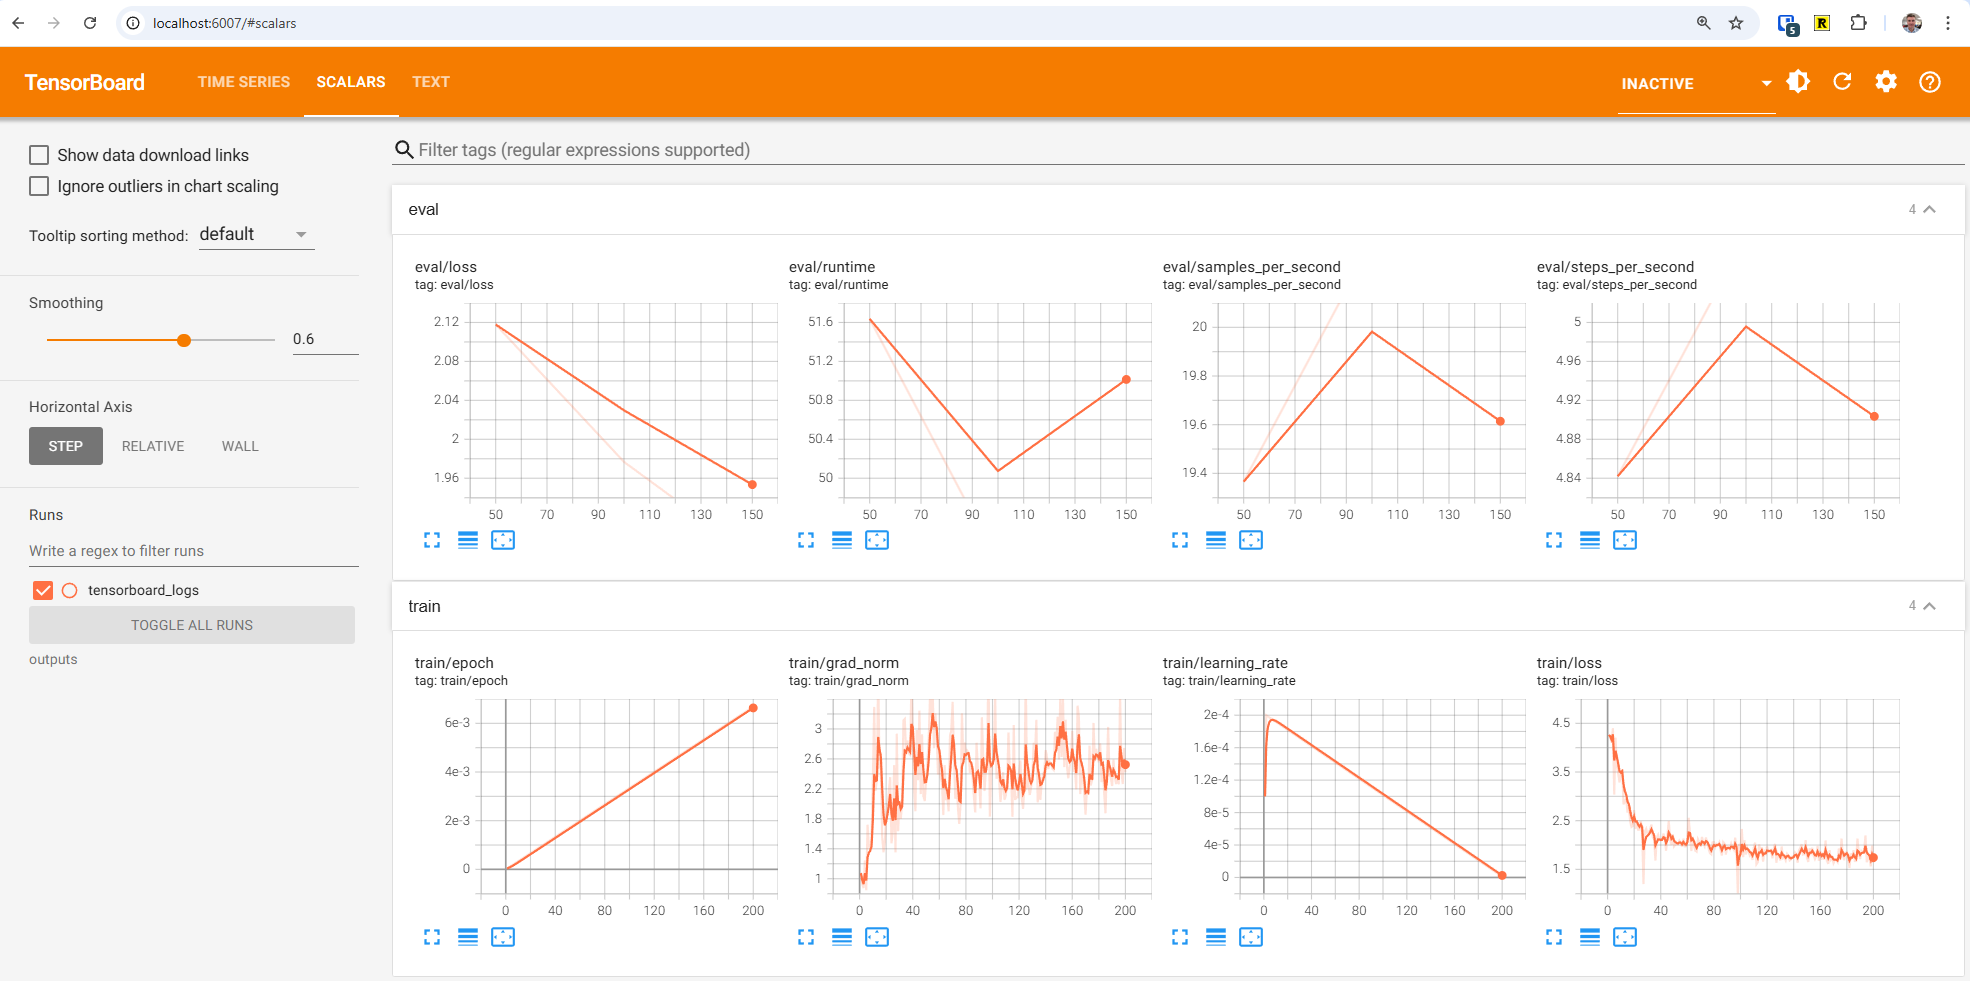


In [18]:
#trainer_stats = trainer.train(resume_from_checkpoint = True)
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 478,778 | Num Epochs = 1 | Total steps = 201
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 6,522,880/1,006,408,832 (0.65% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,1.971700,2.117946
100,1.903000,1.976880
150,1.735400,1.880399
200,1.637600,1.830169


Unsloth: Will smartly offload gradients to save VRAM!


Unsloth: Not an error, but Gemma3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Do a quick test of the model once training is complete.

A successful run should return Morse Code for a given English input, and English for a given Morse Code input.
If the output isn't accurate, additional training may be needed.

In [19]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)
messages = [{
    "role": "user",
    "content": [{
        "type" : "text",
        "text" : "Hello World.",
    }]
}]

text = tokenizer.apply_chat_template(
    messages,
    tokenize= False,
    add_generation_prompt = True, # Must add for generation
)

outputs = model.generate(
    **tokenizer([text], return_tensors = "pt").to("cuda"),
    max_new_tokens = 200, # Increase for longer outputs
    temperature = 1, top_p = 0.95, top_k = 64, # Recommended Gemma-3 settings!
)

output = tokenizer.batch_decode(outputs)[0]
print(output)

from decode import decode_from_morse
import re

match = re.search(r'<start_of_turn>model\n(.*?)<eos>', output, re.DOTALL)
if match:
    result = match.group(1)
    print(decode_from_morse(result))
else:
    print("No match found.")
    

<bos><bos><start_of_turn>user
Hello World.<end_of_turn>
<start_of_turn>model
.. / .... .- ... / -.. --- .--. -. . -.. / .. -. / .-- .... ..- ... . -.- . .-. . / .... .. -- / .- -. -.. / -.-. .- ... / .-- --- / ... .-.. --- - .-. . . ... / .-- --- - .... . / - --- / .--. . .- .-. . ...- .-. -. ... - / ... .... . / .- -. -.. / . .- ... / - .... . / --- ..-. / .-- .... ..- .-. -.. . / .-.. --- --- -. . -.- . / ... .. - / -.-. --- --- ..- - .... . -.. / -.-. .- ...- . / -- -. -.-. - .... . .-. . .. -.-. - --- . / .-- .... ..- .-. -.. / .... .- .-.. .-. . .-.-.-<eos>
I HAS DOPNED IN WHUSEKERE HIM AND CAS WO SLOTREES WOTHE TO PEAREVRNST SHE AND EAS THE OF WHURDE LOONEKE SIT COOUTHED CAVE MNCTHEREICTOE WHURD HALRE.


## Save the Model locally and to Hugging Face

The existing chat template associated with the tokenizer is a valid Gemma 3 chat template.
However, for this application, it should be replaced with a version that doesn't accumulate conversation history — only the latest message should be used, as in chat applications like LM Studio.

A similar adjustment is needed when building an Ollama model, but it requires a different chat template. See the Ollama folder in this repository for an example.

In [20]:
print(tokenizer.chat_template)

{{ bos_token }}
{%- if messages[0]['role'] == 'system' -%}
    {%- if messages[0]['content'] is string -%}
        {%- set first_user_prefix = messages[0]['content'] + '

' -%}
    {%- else -%}
        {%- set first_user_prefix = messages[0]['content'][0]['text'] + '

' -%}
    {%- endif -%}
    {%- set loop_messages = messages[1:] -%}
{%- else -%}
    {%- set first_user_prefix = "" -%}
    {%- set loop_messages = messages -%}
{%- endif -%}
{%- for message in loop_messages -%}
    {%- if (message['role'] == 'user') != (loop.index0 % 2 == 0) -%}
        {{ raise_exception("Conversation roles must alternate user/assistant/user/assistant/...") }}
    {%- endif -%}
    {%- if (message['role'] == 'assistant') -%}
        {%- set role = "model" -%}
    {%- else -%}
        {%- set role = message['role'] -%}
    {%- endif -%}
    {{ '<start_of_turn>' + role + '
' + (first_user_prefix if loop.first else "") }}
    {%- if message['content'] is string -%}
        {{ message['content'] | trim }}


In [21]:
new_chat_template = """<bos>{% if messages[0]['role'] == 'system' %}
    {% if messages[0]['content'] is string %}
        {% set first_user_prefix = messages[0]['content'] %}
    {% else %}
        {% set first_user_prefix = messages[0]['content'][0]['text'] %}
    {% endif %}
    {% set loop_messages = messages[1:] %}
{% else %}
    {% set first_user_prefix = "" %}
    {% set loop_messages     = messages %}
{% endif %}
{# Only render the very last message #}
{% set message = loop_messages[-1] %}
{# Normalize assistant role to "model" #}
{% if message['role'] == 'assistant' %}
    {% set role = "model" %}
{% else %}
    {% set role = message['role'] %}
{% endif %}
{{ '<start_of_turn>' + role + first_user_prefix }}
{% if message['content'] is string %}
{{ message['content'] | trim }}
{% elif message['content'] is iterable %}
    {% for item in message['content'] %}
        {% if item['type'] == 'image' %}
            {{ '<start_of_image>' }}
        {% elif item['type'] == 'text' %}
{{ item['text'] | trim }}{% endif %}{% endfor %}
{% else %}{{ raise_exception('Invalid content type') }}{% endif %}{{ '<end_of_turn>
<start_of_turn>model
' }}
"""

new_chat_template = re.sub(r'\n+', '\n', new_chat_template)
new_chat_template

'<bos>{% if messages[0][\'role\'] == \'system\' %}\n    {% if messages[0][\'content\'] is string %}\n        {% set first_user_prefix = messages[0][\'content\'] %}\n    {% else %}\n        {% set first_user_prefix = messages[0][\'content\'][0][\'text\'] %}\n    {% endif %}\n    {% set loop_messages = messages[1:] %}\n{% else %}\n    {% set first_user_prefix = "" %}\n    {% set loop_messages     = messages %}\n{% endif %}\n{# Only render the very last message #}\n{% set message = loop_messages[-1] %}\n{# Normalize assistant role to "model" #}\n{% if message[\'role\'] == \'assistant\' %}\n    {% set role = "model" %}\n{% else %}\n    {% set role = message[\'role\'] %}\n{% endif %}\n{{ \'<start_of_turn>\' + role + first_user_prefix }}\n{% if message[\'content\'] is string %}\n{{ message[\'content\'] | trim }}\n{% elif message[\'content\'] is iterable %}\n    {% for item in message[\'content\'] %}\n        {% if item[\'type\'] == \'image\' %}\n            {{ \'<start_of_image>\' }}\n      

Save a merged model to your local file system.

In [22]:
if True: # Change to True to save finetune!
    tokenizer.chat_template = new_chat_template
    model.save_pretrained_merged("bi-morse-code-demo", tokenizer)

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:18<00:00, 18.17s/it]


Then push it to Hugging Face, make sure to set the repo name to yours.
This will be saved in a **SafeTensor** format.

In [23]:
if True: # Change to True to upload finetune
    model.push_to_hub_merged(
        "philipfourie/bi-morse-code-demo", 
        tokenizer,
    )

  0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:49<00:00, 49.74s/it]


## GGUF Saving

As of 2025/04/26, there is an open [issue](https://github.com/unslothai/unsloth/issues/1416) with Unsloth where Gemma 3 is not yet supported, and the code below does not work at this time.  
I'm leaving it here in case the issue is resolved in the future.

In the meantime, you can use a workaround: convert the SafeTensor model that was uploaded to Hugging Face in the previous step by running it through the [gguf-my-repo](https://huggingface.co/spaces/ggml-org/gguf-my-repo) tool.


In [24]:
if False: # Change to True to save to GGUF
    model.save_pretrained_gguf(
        "bi-morse-code-demo",
        quantization_type = "Q8_0", # For now only Q8_0, BF16, F16 supported
    )

In [25]:
if False: # Change to True to upload GGUF
    model.push_to_hub_gguf(
        "bi-morse-code-demo",
        quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported
        repo_id = "philipfourie/bi-morse-code-demo_Q8_0"
    )